c:\Users\omarc\miniconda3\envs\pywork\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


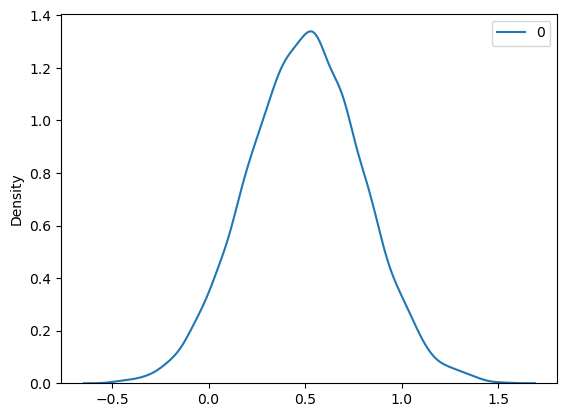

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.autograd import Variable

data_size = 10000
data_mean = 0.5
data_std = 0.3
torch.manual_seed(40)
np.random.seed(40)
data = torch.normal(data_mean, data_std, size=(data_size, 1))

sns.kdeplot(data, color= 'green')
plt.show()
# Define the generator network


In [3]:
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, output_dim),
           
        )
    
    def forward(self, x):
        return self.fc(x)

# Define the discriminator network
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, input_dim),
           
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.fc(x)



In [4]:
# Hyperparameters
lr = 0.001
z_dim = 64  # Latent vector dimension
data_dim = 1  # Output dimension (assuming 1D Gaussian distribution)
batch_size = 100
num_epochs = 10000
target_mean = 0.5
target_std = 0.3
# Initialize networks
generator = Generator(data_dim,  data_dim)
discriminator = Discriminator(data_dim)
lambda_ = 0.1

training_data = np.random.normal(target_mean, target_std, size=(1000, 1))
# Loss function and optimizers
criterion = nn.BCELoss()
r_loss = nn.MSELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=lr)
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr)

D_loss, G_loss, mean_kl = [], [], []

In [5]:
def kl_divergence(mu1, sigma1, mu2, sigma2):
    """
    Calculate the KL divergence between two Gaussian distributions.
    
    Args:
        mu1 (float): Mean of the first Gaussian distribution.
        sigma1 (float): Standard deviation of the first Gaussian distribution.
        mu2 (float): Mean of the second Gaussian distribution.
        sigma2 (float): Standard deviation of the second Gaussian distribution.
    
    Returns:
        float: KL divergence value.
    """
    kl = (np.log(sigma2 / sigma1) + (sigma1**2 + (mu1 - mu2)**2) / (2 * sigma2**2) - 0.5).numpy()
    return kl

In [6]:
# Training loop
for epoch in range(num_epochs):
    # Generate random noise
    noise = torch.randn(batch_size, data_dim)
    
    
    # Generate fake data from noise
    fake_data = generator(noise)

    data = torch.Tensor(training_data[np.random.randint(0, 1000, size=batch_size)])
   
    #real_labels = torch.ones(batch_size, 1)
    #fake_labels = torch.zeros(batch_size, 1)

    # Train discriminator with real data
    discriminator.zero_grad()
    real_output = discriminator(data)
    
    #loss_real.backward(retain_graph=True)
    # Train discriminator with fake data
    

    fake_output = discriminator(fake_data.detach())
    loss_real = criterion(real_output, torch.ones_like(real_output))
    loss_fake = criterion(fake_output, torch.zeros_like(fake_output))
    
    
    loss_d = loss_real + loss_fake
    loss_d.backward()
    optimizer_d.step()

    # Train generator
    generator.zero_grad()
    fake_data = generator(noise)
    fake_output = discriminator(fake_data)
    loss_g = criterion(fake_output, torch.ones_like(fake_output))
    reg_loss_mean = 0.1* r_loss(torch.mean(fake_data), torch.tensor(target_mean))
    reg_loss_std = 0.1 * r_loss(torch.std(fake_data), torch.tensor(target_std))
    (loss_g + reg_loss_mean + reg_loss_std).backward()
    optimizer_g.step()
    D_loss.append(loss_d.item())
    G_loss.append(loss_g.item())

    generated_samples = fake_data.detach().numpy()
    d_mean = data.mean()
    d_std = data.std()
    g_mean = generated_samples.mean()
    g_std = generated_samples.std()
    kl = kl_divergence(g_mean, g_std, d_mean, d_std)
    mean_kl.append(kl)
    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
        print(f"Epoch [{epoch}/{num_epochs}] Loss D: {D_loss}, Loss G: {G_loss}")
        print("KL_divergence:", kl)
        
noise = torch.randn(1000, data_dim)
generated_samples = generator(noise).detach().numpy()

generated_mean = np.mean(generated_samples)
generated_std = np.std(generated_samples)
print(f"Generated Samples Mean: {generated_mean:.4f}, Generated Samples Std: {generated_std:.4f}")
print("average KL_divergence:", np.mean(mean_kl))

Epoch [0/10000] Loss D: [1.278912901878357], Loss G: [0.6566287279129028]
KL_divergence: 0.67057633
Epoch [1000/10000] Loss D: [1.278912901878357, 1.2727423906326294, 1.3033503293991089, 1.2579777240753174, 1.2793664932250977, 1.2974718809127808, 1.2822455167770386, 1.2653849124908447, 1.2520909309387207, 1.2736918926239014, 1.2665218114852905, 1.2878599166870117, 1.2824316024780273, 1.266610026359558, 1.2953240871429443, 1.2685294151306152, 1.29268217086792, 1.3115379810333252, 1.2764673233032227, 1.2809029817581177, 1.2664475440979004, 1.270898699760437, 1.3207132816314697, 1.3001770973205566, 1.2771415710449219, 1.2969682216644287, 1.288787841796875, 1.2637228965759277, 1.2867525815963745, 1.2795038223266602, 1.2607827186584473, 1.2870614528656006, 1.2834851741790771, 1.2962424755096436, 1.2894563674926758, 1.2732292413711548, 1.2905704975128174, 1.3199000358581543, 1.2545673847198486, 1.2696948051452637, 1.2872259616851807, 1.2819242477416992, 1.2705974578857422, 1.2930675745010376

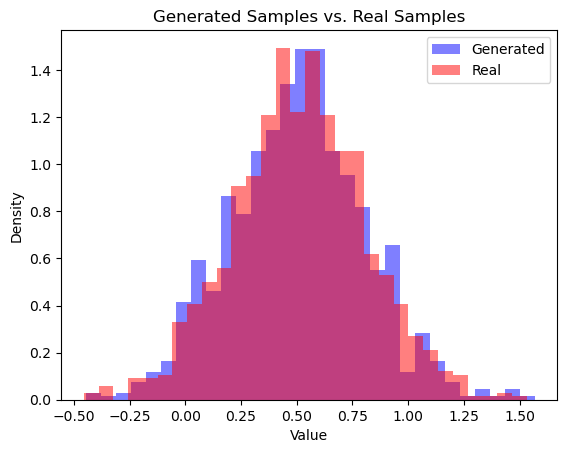

In [7]:
import matplotlib.pyplot as plt
# Plot histogram of the generated samples
plt.hist(generated_samples, bins=30, density=True, alpha=0.5, label='Generated', color='blue')
plt.hist(training_data, bins=30, density=True, alpha=0.5, label='Real', color='red')
plt.legend()
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Generated Samples vs. Real Samples')
plt.show()

c:\Users\omarc\miniconda3\envs\pywork\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\omarc\miniconda3\envs\pywork\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


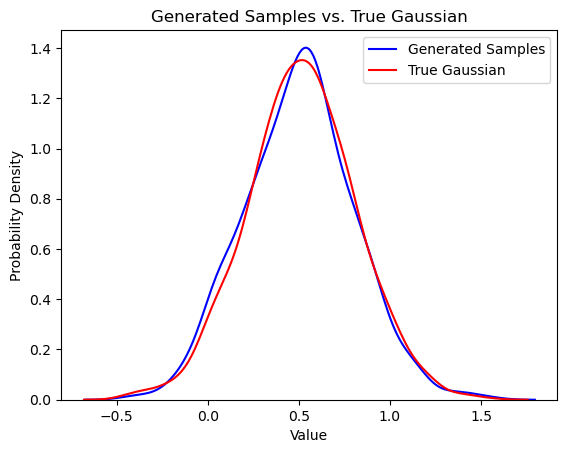

In [8]:

sns.kdeplot(generated_samples.squeeze(), color='b', label='Generated Samples')
#x = np.linspace(-3, 3, 100)
sns.kdeplot(training_data.squeeze(),color ='r', label='True Gaussian')
plt.legend()
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.title('Generated Samples vs. True Gaussian')
plt.show()

In [9]:
def kl_divergence(mu1, sigma1, mu2, sigma2):
    """
    Calculate the KL divergence between two Gaussian distributions.
    
    Args:
        mu1 (float): Mean of the first Gaussian distribution.
        sigma1 (float): Standard deviation of the first Gaussian distribution.
        mu2 (float): Mean of the second Gaussian distribution.
        sigma2 (float): Standard deviation of the second Gaussian distribution.
    
    Returns:
        float: KL divergence value.
    """
    kl = (np.log(sigma2 / sigma1) + (sigma1**2 + (mu1 - mu2)**2) / (2 * sigma2**2) - 0.5)
    return kl

reconstructed_mean = np.mean(generated_samples)
reconstructed_std = np.std(generated_samples)
kl = print("Test KL", kl_divergence(reconstructed_mean, reconstructed_std, 0.5, 0.3))

Test KL 4.2790959017047214e-05
